Evan Chandran, October 5 – Implementation of Value Function iteration for $W(\eta)$. 

In [1]:
# 10-5 notes:
# 1) weird features of initial guess can cause an iota to be very negative -> 
# can cause Phi = 1/phi * log(1+phi * iota) to be undefined. Current values work ok. 

# Setup

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import seaborn as sns
import pandas as pd


In [63]:
# parameters
rho = 0.05
A_1 = 0.10
A_2 = 0.12
phi = 10
delta = 0.05
alpha = 0.5
h_1 = 0.03
h_2 = 0.05                                      # for now, have utility penalty on the order of utility of consumption
Delta_T = 10                                    # step size for backwards iteration of value function. From HW exercise, should scale quadratically in d_eta
max_iter = 100
d_eta = 0.001
dt = 0.5
t_max = 300





eta = np.linspace(0, 1, int(1/d_eta) + 1)
beta = (1 - alpha) / rho




conv_thresh = 1e-6

# Value Function

In [39]:
def Phi(iota):
    return (1 / phi) * np.log(1 + phi * iota)

def W_pr_fwd(W_eta):
    """Return forward step approximation of W' for computing iota_1, iota_2"""
    W_pr = (np.roll(W_eta, -1) - W_eta) / d_eta
    W_pr[-1] = W_pr[-2] # correct last element
    return W_pr

def get_i1(W_pr_eta, eta):
    """Called with vectors in value iteration, with scalars in forward evolution"""
    num = -(phi + beta) + (W_pr_eta * (1 - eta) + beta) * (1 + phi * (eta * A_1 + (1-eta)*A_2))
    denom = phi * (phi + beta)
    return num / denom

def get_i2_solo(i1, eta):
    """For scalars for forward evolution"""
    C_1 = - eta / (1 - eta)
    C_0 = (-1 + beta * (eta * A_1 + (1 - eta) * A_2)) / ((1 - eta) * (phi + beta))
    return i1 * C_1 + C_0 
    

def get_i2_mid(i1_mid):
    """Vectorized for value iteration"""
    eta_mid = eta[1:-1]
    C_1 = - eta_mid / (1 - eta_mid)
    C_0 = (-1 + beta * (eta_mid * A_1 + (1 - eta_mid) * A_2)) / ((1 - eta_mid) * (phi + beta))
    return i1_mid * C_1 + C_0

def get_c_per_k(iota_1, iota_2, eta):
    """Return consumption per unit capital using goods market clearing"""
    return (A_1 - iota_1) * eta + (A_2 - iota_2) * (1-eta)

def get_iotas(W_pr_eta):
    """return 2*n array iota_1, iota_2 as functions of W'"""
    iotas = np.zeros((2, len(eta)))
    iotas[:, 0] = np.array([1, (beta*A_2 - 1) / (phi + beta)])  # later: replace 1 with left/right limit
    iotas[:, -1] = np.array([(beta*A_1 - 1) / (phi + beta), 1])
    i1_mid = get_i1(W_pr_eta[1:-1], eta[1:-1])
    i2_mid = get_i2_mid(i1_mid)
    iotas[:, 1:-1] = np.stack([i1_mid, i2_mid])
    return iotas

def get_mu_eta(iotas):
    return eta * (1 - eta) * (Phi(iotas[0, :]) - Phi(iotas[1, :]))

def build_U(iotas):
    i1, i2 = iotas
    x = (A_1 - i1) * eta + (A_2 - i2) * (1 - eta)
    U = np.log(x) - alpha * np.log(h_1 * eta + h_2 * (1 - eta)) + beta * (eta * Phi(i1) + (1 - eta) * Phi(i2) - delta)
    return U

def build_M(mu_eta):
    dD = Delta_T * np.min(np.stack([mu_eta, np.zeros(len(eta))]), axis=0) / d_eta
    dM = 1 + rho * Delta_T + Delta_T * (np.max(np.stack([np.zeros(len(eta)), mu_eta]), axis=0) - 
                        np.min(np.stack([mu_eta, np.zeros(len(eta))]), axis=0)) / d_eta
    dU = - Delta_T * np.max(np.stack([mu_eta, np.zeros(len(eta))]), axis=0) / d_eta
    dUf = np.roll(dU, 1)  # necessary for diagonals to all start on the same row
    dDb = np.roll(dD, -1)  
    
    M = spdiags([dDb, dM, dUf], [-1, 0, 1], len(eta), len(eta)).toarray()
    
    # these should be 0 anyways since mu_eta = 0 at bounds, but need to ensure fwd diff @ 0, backward diff @ N
    assert M[0, 1] == -Delta_T * mu_eta[0] / d_eta  
    assert M[-1, -2] == Delta_T * mu_eta[-1] / d_eta
    
    return M


def W_iteration(W_guess):
    err = 1
    W_curr = W_guess
    for i in range(max_iter):
        W_pr_eta = W_pr_fwd(W_curr)
        iotas = get_iotas(W_pr_eta)
        mu_eta = get_mu_eta(iotas)
        M = build_M(mu_eta)
        U = build_U(iotas)
        # computational step. With d_eta = 0.001, approx 0.03 sec / iter
        W_next = np.linalg.inv(M) @ (Delta_T * U + W_curr)
        err = np.max(np.abs(W_next - W_curr))
        if err < conv_thresh:
            print(f"Value function convergence reached at iter {i+1}!")
            break
        elif i % (max_iter / 10) == 0:
            print(f"Error after iter {i+1}: {err}")
        W_curr = W_next
    return W_next

# $W(\eta)$

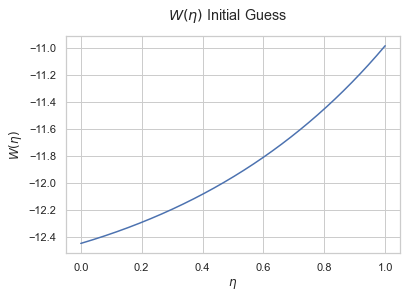

In [40]:
# we want some analogy of V = u(w * n) / rho, but here we are guessing w, not v. 
# this guess is the utility over the next timestep assuming no reinvestment. We'll scale up by 1/rho. 
W_guess = (1 / rho) * (np.log(eta * A_1 + (1 - eta) * A_2) - alpha * np.log(h_1 * eta + h_2 * (1 - eta))) 

fig, ax = plt.subplots()
ax.plot(eta, W_guess)
ax.set_xlabel("$\eta$")
ax.set_ylabel("$W(\eta)$")

plt.suptitle("$W(\eta)$ Initial Guess")
plt.show()

In [41]:
w_sol = W_iteration(W_guess)

Error after iter 1: 3.333333333333334
Error after iter 11: 0.0578050997194417
Error after iter 21: 0.0010024288660730463
Error after iter 31: 1.7383650167346332e-05
Value function convergence reached at iter 39!


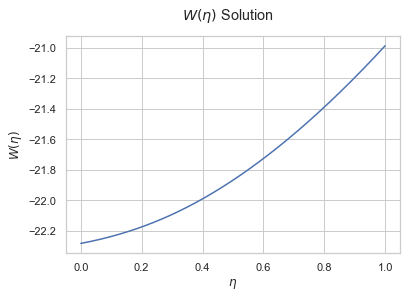

In [42]:
fig, ax = plt.subplots()
ax.plot(eta, w_sol)
ax.set_xlabel("$\eta$")
ax.set_ylabel("$W(\eta)$")

plt.suptitle("$W(\eta)$ Solution")
plt.show()

Error after iter 1: 4.735784974679826
Error after iter 11: 0.08212575681335821
Error after iter 21: 0.0014241862686397155
Error after iter 31: 2.4697568782983126e-05
Value function convergence reached at iter 39!


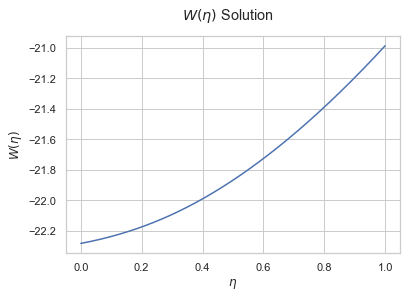

In [43]:
# sanity check: shouldn't depend on initial guess
W_guess_2 = W_guess + 5 * np.sin(eta)
w_sol_2 = W_iteration(W_guess_2)
fig, ax = plt.subplots()
ax.plot(eta, w_sol_2)
ax.set_xlabel("$\eta$")
ax.set_ylabel("$W(\eta)$")
plt.suptitle("$W(\eta)$ Solution")
plt.show()

In [44]:
# next steps: 1) would we want params such that max at eta=1 or somewhere in the interior?

# Results

In [64]:
N_t = int(t_max / dt)
W_set = w_sol  # use known value function computed above 
W_pr_set = W_pr_fwd(W_set)
K_0 = 1
eta_0 = 0.2

## Value Function, Investment Rates, Consumption vs eta

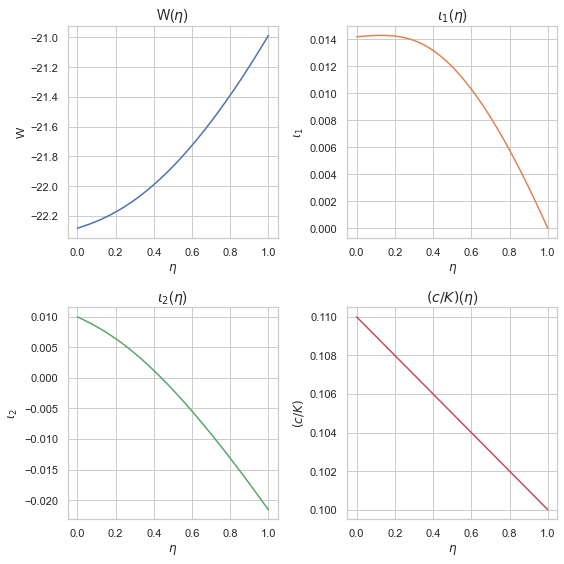

In [65]:
iotas_eta = get_iotas(W_pr_set)
iota_1, iota_2 = iotas_eta
iotas = get_iotas(W_pr_fwd(W_pr_set))  # investment rates as functions of state variable
iota_1[0] = iota_1[1] # overwrite dummy value of 1
iota_2[-1] = iota_2[-2] # same here
c_per_k = get_c_per_k(iota_1, iota_2, eta)


data = pd.DataFrame({
    'eta': eta,
    'W': W_set,
    '$\iota_1$': iota_1,
    '$\iota_2$': iota_2,
    '$(c/K)$': c_per_k
})

# Set up Seaborn style
sns.set(style="whitegrid")

# Create subplots for each time series
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Titles for each subplot
axs2 = axs.flatten()

# Plot each series
for i, col in enumerate(data.columns[1:]):
    sns.lineplot(x='eta', y=col, data=data, ax=axs2[i], color=f'C{i}')
    axs2[i].set_title(f"{col}($\eta$)", fontsize=14)
    axs2[i].set_ylabel(col)
    axs2[i].set_xlabel('$\eta$')

# Set the common x-axis label
plt.xlabel('$\eta$', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()




## Time Evolution of Economy

In [66]:
def update_state(eta_n, K_n):
    """Propagate eta forward by one timestep via one-step newton's method"""
    eta_index = int(eta_n // d_eta)  
    W_pr_approx = W_pr_set[eta_index]
    i1 = get_i1(W_pr_approx, eta_n)
    i2 = get_i2_solo(i1, eta_n)
    f_n =  - dt*eta_n*(1-eta_n) * (Phi(i1) - Phi(i2)) 
    f_n_pr = 1 - dt*(1-2*eta_n) * (Phi(i1) - Phi(i2))
    eta_n1 = eta_n - f_n / f_n_pr
    K_n1 = K_n / (1 - dt*(eta_n1 * (Phi(i1) - delta) + (1 - eta_n1) * (Phi(i2) - delta)))
    return eta_n1, K_n1

def evolve_economy(eta_0, K_0):
    eta_t = np.zeros(N_t)
    K_t = np.zeros(N_t)
    eta_t[0] = eta_0
    K_t[0] = K_0
    for i in range(1, N_t):
        eta_t[i], K_t[i] = update_state(eta_t[i-1], K_t[i-1])
    return eta_t, K_t

## $K_t$, $\eta_t$, $\iota^1_t$, $\iota^2_t$, $c_t$

In [67]:
t = np.arange(N_t) * dt
eta_t, K_t = evolve_economy(eta_0, K_0)
iota_1_t = np.array([iota_1[(int(et // d_eta))] for et in eta_t])
iota_2_t = np.array([iota_2[(int(et // d_eta))] for et in eta_t])
# under log utility, consuption is just rho * net worth
c_t = K_t * get_c_per_k(iota_1_t, iota_2_t, eta_t)

# fig, axs = plt.subplots(2)
# axs[0].plot(t, eta_t)
# axs[0].set_xlabel("t")
# axs[0].set_ylabel("$\eta_t$")
# axs[1].plot(t, K_t)
# axs[1].set_xlabel("t")
# axs[1].set_ylabel("$K_t$")
# plt.suptitle(f"$\eta_t$ and $K_t$ evolution, dt = {dt}")
# plt.show()

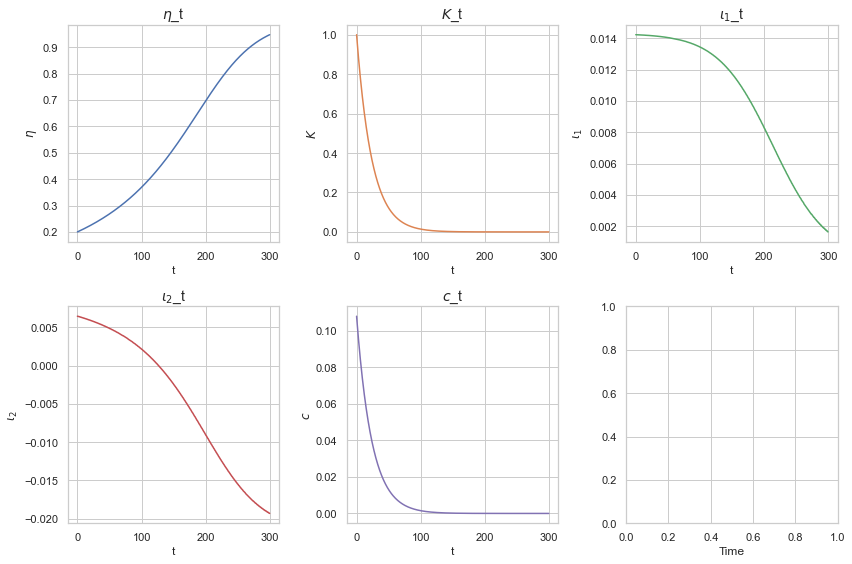

In [68]:
# GPT 
np.random.seed(0)
data = pd.DataFrame({
    'Time': t,
    '$\eta$': eta_t,
    '$K$': K_t,
    '$\iota_1$': iota_1_t,
    '$\iota_2$': iota_2_t,
    '$c$': c_t,
})

# Set up Seaborn style
sns.set(style="whitegrid")

# Create subplots for each time series
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Titles for each subplot
axs2 = axs.flatten()

# Plot each series
for i, col in enumerate(data.columns[1:]):
    sns.lineplot(x='Time', y=col, data=data, ax=axs2[i], color=f'C{i}')
    axs2[i].set_title(f"{col}_t", fontsize=14)
    axs2[i].set_ylabel(col)
    axs2[i].set_xlabel('t')

# Set the common x-axis label
plt.xlabel('Time', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


# Scratch

In [ ]:
######### Note (1/15/25): this method is wrong, as we are also varying over time. 

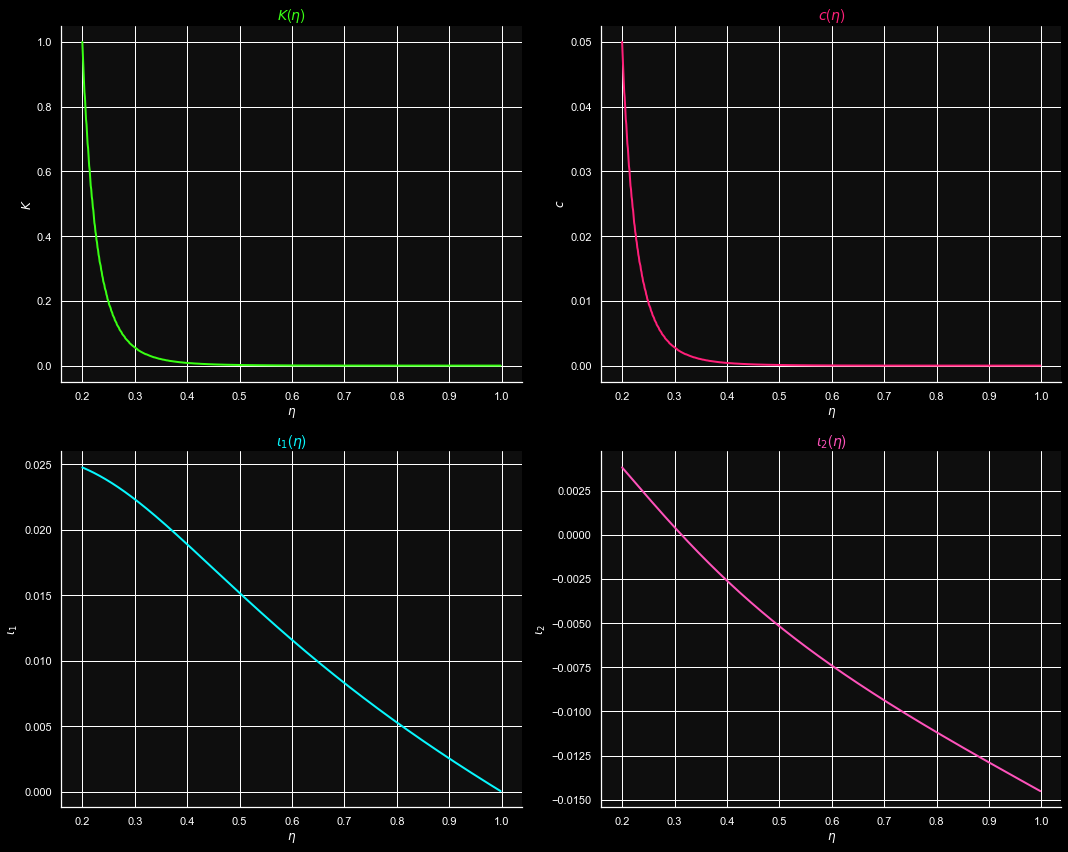

In [39]:
# # interpolate K as fn of eta
# eta_start_id = int(eta_0 // d_eta)
# eta_end_id = int(eta_t[-1] // d_eta)
# eta_range = eta[eta_start_id:eta_end_id]
# eta_indices = np.searchsorted(eta_t, eta_range)
# K_eta = np.array([K_t[index] for index in eta_indices])
# c_eta = rho * K_eta
# iota_1_eta = iota_1[eta_start_id:eta_end_id]
# iota_2_eta = iota_2[eta_start_id:eta_end_id]

# fns_of_eta = pd.DataFrame({
#     '$\eta$': eta_range,
#     '$K$': K_eta,
#     '$c$': c_eta,
#     '$\iota_1$': iota_1_eta,
#     '$\iota_2$': iota_2_eta
# })

# # GPT
# plt.style.use('dark_background')

# # Set up custom colors for neon effect
# neon_colors = ['#39FF14', '#FF2079', '#08F7FE', '#FE53BB', '#F5D300']

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

axs = axs.flatten()

# Plot each series
for i, col in enumerate(fns_of_eta.columns[1:]):
    sns.lineplot(x='$\eta$', y=col, data=fns_of_eta, ax=axs[i], color=neon_colors[i], linewidth=2)
    axs[i].set_title(f"{col}($\eta$)", fontsize=14, color=neon_colors[i])
    axs[i].set_ylabel(col, color='white')
    axs[i].set_xlabel('$\eta$')
    axs[i].tick_params(axis='y', colors='white')
    axs[i].tick_params(axis='x', colors='white')
    axs[i].spines['left'].set_color('white')
    axs[i].spines['bottom'].set_color('white')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_facecolor('#0E0E0E')

plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
############ NOW: LITERATURE REVIEW: GO TO GOOLE SCHOLAR, LOOK FOR "MACRO CLIMATE PAPERS"
#### Get a range of parameters from these papers!!!!! Set units & adapt from there. take one week on this. 